In [1]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
def rs(state, action, a, b, c, d, r, l):
    stp = rt = None
    if state == a and action == r:
        stp, rt = c, 0
    elif state == a and action == l:
        stp, rt = b, 0
    elif state == b:
        stp, rt = d, rv + np.random.randn()
    return stp, rt


def rbar(state, action, a, b, r, l, rv):
    if state == a and (action == r or action == l):
        return 0
    elif state == b:
        return rv
    else:
        return 0

def update(state, action, Q, a, b, c, d, r, l):
    maxQ = np.zeros(4)
    for s in range(4):
        maxQ[s] = np.max(Q[s])
    if state == a and action == r:
        return maxQ[c]
    elif state == a and action == l:
        return maxQ[b]
    elif state == b:
        return maxQ[d]
    else:
        return 0


def zeroQ(Q):
    for i in range(4):
        Q[i].fill(0.0)

def alphat(alpha0, t):
    return alpha0 / (1 + 0.001 * t)

def softprob(x):
    x = x - np.max(x)
    x = np.exp(x)
    return x / np.sum(x)

def argmaxR(x):
    p = softmax(1000 * x)
    return np.random.choice(np.arange(len(x)), p=p)

# define states and actions
a, b, c, d = 0, 1, 2, 3
l, r = 0, 1

rv = -0.1
gamma = 0.99
alpha0 = 0.1
eps = 0.1
Exps = 10000
Episodes = 2000

# Initialization
Q = [np.zeros((2,)), np.zeros((8,)), np.zeros((1,)), np.zeros((1,))]
zeroQ(Q)

QA = [np.copy(q) for q in Q]
QB = [np.copy(q) for q in Q]

# Get the true solution to the MDP
Qnew = deepcopy(Q)
zeroQ(Qnew)

for _ in range(1000):
    for state in [a, b, c, d]:
        for action in range(len(Q[state])):
            Qnew[state][action] = rbar(state, action, a, b, r, l, rv) + gamma * update(state, action, Q, a, b, c, d, r, l)
    Q = deepcopy(Qnew)

QmaxTrue = Q[a][l]

# Initialize other necessary variables
Qend = np.zeros((Exps, Episodes))
dQend = np.zeros((Exps, Episodes))
sQend = np.zeros((Exps, Episodes))
cQend = np.zeros((Exps, Episodes))

adQend = np.zeros((Exps, Episodes))
gQend = np.zeros((Exps, Episodes))
lQend = np.zeros((Exps, Episodes))

In [3]:
# Standard Q learning
# start_time = time.time()
actionsQ = []

for experiment in range(Exps):
    zeroQ(Q)
    ct = [0]
    actionsQ_ex = []
    for episode in range(Episodes):
        st = [a]
        at = [0] # dummy initialization
        while True:
            ct[0] += 1
            alpha = alphat(alpha0, ct[0])
            if np.random.rand() > eps: # select action using maxQ
                at[0] = argmaxR(Q[st[0]])
            else:
                at[0] = np.random.choice([0, 1])
            actionsQ_ex.append(at[0])
            stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
            Q[st[0]][at[0]] += alpha * (rt + gamma * np.max(Q[stp]) - Q[st[0]][at[0]])
            if stp == d or stp == c:
                break
            st[0] = stp
        Qend[experiment, episode] = Q[a][l]
    actionsQ.append(actionsQ_ex)

In [4]:
# Double Q learning
# start_time = time.time()
actionsdQ = []
for experiment in range(Exps):
    zeroQ(QA)
    zeroQ(QB)
    ct = [0]
    actionsdQ_ex = []
    for episode in range(Episodes):
        st = [a]
        at = [1]
        while True:
            ct[0] += 1
            alpha = alphat(alpha0, ct[0])
            if np.random.rand() > eps: # select action using maxQ
                at[0] = argmaxR(QA[st[0]])
            else:
                at[0] = np.random.choice([0, 1])
            actionsdQ_ex.append(at[0])
            stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
            if np.random.rand() > 0.5: # update A
                astar = argmaxR(QA[stp])
                QA[st[0]][at[0]] += alpha * (rt + gamma * QB[stp][astar] - QA[st[0]][at[0]])
            else: # update B
                bstar = argmaxR(QB[stp])
                QB[st[0]][at[0]] += alpha * (rt + gamma * QA[stp][bstar] - QB[st[0]][at[0]])
            if stp == d or stp == c:
                break
            st[0] = stp
        dQend[experiment, episode] = QA[a][l]
    actionsdQ.append(actionsdQ_ex)

In [5]:
# Smoothed Q learning (softmax)
# start_time = time.time()
actionssQ = []
q = deepcopy(Q)
for experiment in range(Exps):
    zeroQ(Q)
    ct = [0]
    actionssQ_ex = []
    for episode in range(Episodes):
        st = [a]
        at = [0]
        beta = 0.1 + 0.1 * (episode - 1)
        while True:
            for s in range(4):
                q[s] = softmax(beta * Q[s])
            ct[0] += 1
            alpha = alphat(alpha0, ct[0])
            if np.random.rand() > eps: # select action using maxQ
                at[0] = argmaxR(Q[st[0]])
            else:
                at[0] = np.random.choice([0, 1])
            actionssQ_ex.append(at[0])
            stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
            Q[st[0]][at[0]] += alpha * (rt + gamma * np.sum(q[stp] * Q[stp]) - Q[st[0]][at[0]])
            if stp == d or stp == c:
                break
            st[0] = stp
        sQend[experiment, episode] = Q[a][l]
    actionssQ.append(actionssQ_ex)
# print("Smoothed Q Learning (softmax) took %s seconds" % (time.time() - start_time))


# print("Smoothed Q Learning Clipped max took %s seconds" % (time.time() - start_time))

In [6]:
# Clipped max smoothed Q learning
# start_time = time.time()
actionscQ = []
q = deepcopy(Q)
for experiment in range(Exps):
    zeroQ(Q)
    ct = [0]
    actionscQ_ex = []
    for episode in range(Episodes):
        st = [a]
        at = [1]
        mu = np.exp(-0.02 * episode)
        A = 2 # number of actions
        while True:
            for s in range(4):
                A = len(Q[s])
                q[s] = np.ones(A) * mu / (A - 1) if A != 1 else np.ones(A)
                as_ = argmaxR(Q[s])
                q[s][as_] = 1 - mu
                if len(q[s]) == 1:
                    q[s] = 1.0
            ct[0] += 1
            alpha = alphat(alpha0, ct[0])
            if np.random.rand() > eps: # select action using maxQ
                at[0] = argmaxR(Q[st[0]])
            else:
                at[0] = np.random.choice([0, 1])
            actionscQ_ex.append(at[0])
            stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
            Q[st[0]][at[0]] += alpha * (rt + gamma * np.sum(q[stp] * Q[stp]) - Q[st[0]][at[0]])
            if stp == d or stp == c:
                break
            st[0] = stp
        cQend[experiment, episode] = Q[a][l]
    actionscQ.append(actionscQ_ex)

In [23]:
def clipped_softmax(Q_values, beta, clip_min=0.01):
    exp_values = np.exp(beta * Q_values)
    probabilities = exp_values / np.sum(exp_values)
    probabilities = np.maximum(probabilities, clip_min)
    probabilities /= np.sum(probabilities)

    return probabilities

csQend = np.zeros((Exps, Episodes))

actionscsQ = []
q = deepcopy(Q)
for experiment in range(Exps):
    zeroQ(Q)
    ct = [0]
    actionscsQ_ex = []
    for episode in range(Episodes):
        st = [a]
        at = [0]
        beta = 0.1 + 0.1 * (episode - 1)
        while True:
            for s in range(4):
                q[s] = clipped_softmax(Q[s], beta, clip_min=0.01) 
            ct[0] += 1
            alpha = alphat(alpha0, ct[0])
            if np.random.rand() > eps: # select action using maxQ
                at[0] = argmaxR(Q[st[0]])
            else:
                at[0] = np.random.choice([0, 1])
            actionscsQ_ex.append(at[0])
            stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
            Q[st[0]][at[0]] += alpha * (rt + gamma * np.sum(q[stp] * Q[stp]) - Q[st[0]][at[0]])
            if stp == d or stp == c:
                break
            st[0] = stp
        csQend[experiment, episode] = Q[a][l]
    actionscsQ.append(actionscsQ_ex)

In [10]:
bQend = np.zeros((Exps, Episodes))

mu_prior = -0.1  # Based on game mechanism for reward's mean
sigma_prior = 1   # Initial uncertainty
# sigma_observation = 1  # Known observation noise

def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def update_posterior(mu_prior, sigma_prior, rewards):
    epsilon = 1e-10
    sigma_min = 1e-5
    sigma_observation = 1
    sigma_prior = max(sigma_prior, sigma_min)
    denominator = (1 / sigma_prior**2 + len(rewards) / sigma_observation**2)
    sigma_posterior = 1 / max(denominator, epsilon)
    mu_posterior = sigma_posterior * (mu_prior / sigma_prior**2 + np.sum(rewards) / sigma_observation**2)
    return mu_posterior, sigma_posterior

actionsbQ = []
q = deepcopy(Q)
for experiment in range(Exps):
    zeroQ(Q)
    rewards_collected = [] 
    ct = [0]
    actionsbQ_ex = []
    for episode in range(Episodes):
        st = [a]
        mu, _ = update_posterior(mu_prior, sigma_prior, rewards_collected)
        while True:
            adjusted_Q = deepcopy(Q)
            for s in range(len(Q)):
                adjusted_Q[s] += mu
                q[s] = softmax(adjusted_Q[s])
            probabilities = {s: softmax(adjusted_Q[s]) for s in range(len(Q))}

            if np.random.rand() > eps:
                at[0] = argmaxR(Q[st[0]])
            else:
                at[0] = np.random.choice([0, 1])

            actionsbQ_ex.append(at[0])
            stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
            rewards_collected.append(rt)
            expected_reward = np.dot(q[stp], Q[stp])  # Compute expected reward based on action probabilities
            Q[st[0]][at] += alpha * (rt + gamma * expected_reward - Q[st[0]][at])

            if stp == d or stp == c:
                break
            st[0] = stp

        mu_prior, sigma_prior = update_posterior(mu_prior, sigma_prior, rewards_collected)[-2:]
        bQend[experiment, episode] = Q[a][l]
    actionsbQ.append(actionsbQ_ex)

In [ ]:
# #Smoothed Gaussian
# sigma_initial = 0.5
# def compute_q_probabilities(Q_state, beta, sigma):
#     Q_max = np.max(Q_state)
#     exp_part = np.exp(-((Q_state - Q_max) ** 2) / (2 * sigma ** 2))
#     normalization_factor = np.sum(exp_part)
#     return exp_part / normalization_factor
# 
# actionsgQ = []
# q = deepcopy(Q)
# for experiment in range(Exps):
#     zeroQ(Q)
#     ct = [0]
#     actionsgQ_ex = []
#     for episode in range(Episodes):
#         st = [a]
#         at = [0]
#         beta = 0.1 + 0.1 * (episode - 1)
#         sigma = sigma_initial * (1 - episode / Episodes)
#         while True:
#             for s in range(4):
#                 q[s] = compute_q_probabilities(Q[s], beta, sigma)
#             ct[0] += 1
#             alpha = alphat(alpha0, ct[0])
#             if np.random.rand() > eps: # select action using maxQ
#                 at[0] = argmaxR(Q[st[0]])
#             else:
#                 at[0] = np.random.choice([0, 1])
#             actionsgQ_ex.append(at[0])
#             stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
#             Q[st[0]][at[0]] += alpha * (rt + gamma * np.sum(q[stp] * Q[stp]) - Q[st[0]][at[0]])
#             if stp == d or stp == c:
#                 break
#             st[0] = stp
#         gQend[experiment, episode] = Q[a][l]
#     actionsgQ.append(actionssQ_ex)

In [ ]:
# #Smoothed logistic
# def compute_q_probabilities_logistic(Q_state, beta, Q_threshold):
#     logistic_part = 1 / (1 + np.exp(-beta * (Q_state - Q_threshold)))
#     normalization_factor = np.sum(logistic_part)
#     return logistic_part / normalization_factor
# 
# lambda_threshold = 0.8
# 
# actionslQ = []
# q = deepcopy(Q)
# for experiment in range(Exps):
#     zeroQ(Q)
#     ct = [0]
#     actionslQ_ex = []
#     for episode in range(Episodes):
#         st = [a]
#         at = [0]
#         beta = 0.1 + 0.1 * (episode - 1)
#         sigma = sigma_initial * (1 - episode / Episodes)
#         while True:
#             for s in range(4):
#                 Q_mean = np.mean(Q[s])
#                 Q_max = np.max(Q[s])
#                 Q_threshold = lambda_threshold * Q_max + (1 - lambda_threshold) * Q_mean
#                 q[s] = compute_q_probabilities_logistic(Q[s], beta, Q_threshold)
#             ct[0] += 1
#             alpha = alphat(alpha0, ct[0])
#             if np.random.rand() > eps: # select action using maxQ
#                 at[0] = argmaxR(Q[st[0]])
#             else:
#                 at[0] = np.random.choice([0, 1])
#             actionslQ_ex.append(at[0])
#             stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
#             Q[st[0]][at[0]] += alpha * (rt + gamma * np.sum(q[stp] * Q[stp]) - Q[st[0]][at[0]])
#             if stp == d or stp == c:
#                 break
#             st[0] = stp
#         lQend[experiment, episode] = Q[a][l]
#     actionslQ.append(actionssQ_ex)

In [ ]:
# class QAttentionTransformer(nn.Module):
#     def __init__(self, state_dim, action_dim, embed_dim):
#         super(QAttentionTransformer, self).__init__()
#         self.state_embed = nn.Linear(state_dim, embed_dim)
#         self.query_embed = nn.Parameter(torch.randn(1, embed_dim))
#         self.key_embed = nn.Linear(action_dim, embed_dim)
#         self.value_embed = nn.Linear(action_dim, embed_dim)
#         self.output_layer = nn.Linear(embed_dim, action_dim)
#         self.scale = torch.sqrt(torch.tensor(embed_dim, dtype=torch.float32))
# 
#     def forward(self, state, q_values):
#         state_emb = self.state_embed(state)
#         query = self.query_embed.expand(state.size(0), -1)
#         key = self.key_embed(q_values)
#         value = self.value_embed(q_values)
# 
#         attention_scores = torch.bmm(query.unsqueeze(1), key.unsqueeze(2)) / self.scale
#         attention_scores = attention_scores.squeeze(2) + q_values
#         attention_weights = torch.softmax(attention_scores, dim=1)
# 
#         action_values = self.output_layer(state_emb)
#         return attention_weights, action_values
# 
# 
# device = torch.device("mps" if torch.cuda.is_available() else "cpu")
# model = QAttentionTransformer(state_dim=4, action_dim=8, embed_dim=128).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
# # 
# # actionadQ = []
# # q = deepcopy(Q)
# # for experiment in range(Exps):
# #     zeroQ(Q)
# #     ct = [0]
# #     actionadQ_ex = []
# #     for episode in range(Episodes):
# #         st = torch.full((1, 4), a, dtype=torch.float32).to(device)
# #         st_index = a
# #         beta = 0.1 + 0.1 * episode
# #         at = [0]
# #         while True:
# #             max_actions = 8
# #             current_q_values = Q[st_index]
# #             if len(current_q_values) < max_actions:
# #                 # Pad the current q_values to have the shape [1, 8]
# #                 padded_q_values = np.pad(current_q_values, (0, max_actions - len(current_q_values)), 'constant', constant_values=(0))
# #                 q_values = torch.tensor(padded_q_values, dtype=torch.float32).unsqueeze(0).to(device)
# #             else:
# #                 q_values = torch.tensor(current_q_values, dtype=torch.float32).unsqueeze(0).to(device)
# #             _, action_logits = model(st, q_values)
# #             action_probs = torch.softmax(action_logits, dim=1)
# #             action_probs = action_probs.squeeze().cpu().detach().numpy()
# #             
# #             if np.random.rand() > eps:
# #                 at[0] = np.argmax(action_probs)
# #             else:
# #                 at[0] = np.random.choice(np.arange(action_probs.size), p=action_probs)
# #                 
# #             actionadQ_ex.append(at)
# #             stp, rt = rs(st[0].item(), at[0], a, b, c, d, r, l)
# #             alpha = alphat(alpha0, ct)
# #             ct += 1
# #             
# #             best_next_action = np.argmax(Q[stp])
# #             current_q_values = Q[stp]
# #             if len(current_q_values) < max_actions:
# #                 padded_q_values_stp = np.pad(current_q_values, (0, max_actions - len(current_q_values)), 'constant', constant_values=(0))
# #             else:
# #                 padded_q_values_stp = current_q_values
# #             weighted_q_next = np.dot(action_probs, padded_q_values_stp)
# #             Q[st[0]][at] += alpha * (rt + gamma * weighted_q_next - Q[st[0]][at])
# #             
# #             if stp == d or stp == c:
# #                 break
# #             st[0] = torch.tensor([stp], dtype=torch.float32)
# #         actionadQ.append(actionadQ_ex)
# #         adQend[experiment, episode] = Q[a][l]
# 
# actionadQ = []
# q = deepcopy(Q)
# for experiment in range(Exps):
#     zeroQ(Q)
#     ct = 0
#     actionadQ_ex = []
#     for episode in range(Episodes):
#         st = torch.zeros((1, 4), dtype=torch.float32).to(device)  # One-hot encoded state tensor
#         st[0, a] = 1  # Initialize state 'a' as active
# 
#         beta = 0.1 + 0.1 * episode
#         while True:
#             state_index = torch.argmax(st[0]).item()  # Get current state index from one-hot vector
#             max_actions = 8
#             current_q_values = Q[state_index]
#             if len(current_q_values) < max_actions:
#                 padded_q_values = np.pad(current_q_values, (0, max_actions - len(current_q_values)), 'constant', constant_values=(0))
#                 q_values = torch.tensor(padded_q_values, dtype=torch.float32).unsqueeze(0).to(device)
#             else:
#                 q_values = torch.tensor(current_q_values, dtype=torch.float32).unsqueeze(0).to(device)
# 
#             _, action_logits = model(st, q_values)
#             action_probs = torch.softmax(action_logits, dim=1).squeeze().cpu().detach().numpy()
#             at = [0]
#             if np.random.rand() > eps:
#                 at[0] = np.argmax(action_probs)
#             else:
#                 at[0] = np.random.choice(np.arange(action_probs.size), p=action_probs)
# 
#             actionadQ_ex.append(at[0])
#             print(st[0])
#             stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
#             alpha = alphat(alpha0, ct)
#             ct += 1
# 
#             st.fill_(0)
#             st[0, stp] = 1
#             current_q_values = Q[stp]
#             padded_q_values_stp = np.pad(current_q_values, (0, max_actions - len(current_q_values)), 'constant', constant_values=(0))
#             weighted_q_next = np.dot(action_probs, padded_q_values_stp)
#             Q[state_index][at[0]] += alpha * (rt + gamma * weighted_q_next - Q[state_index][at[0]])
# 
#             if stp == d or stp == c:
#                 break
#         actionadQ.append(actionadQ_ex)
#         adQend[experiment, episode] = Q[a][l]


In [24]:
avg_abs_error_Q = np.mean(np.abs(Qend - QmaxTrue), axis=0)
avg_abs_error_dQ = np.mean(np.abs(dQend - QmaxTrue), axis=0)
avg_abs_error_sQ = np.mean(np.abs(sQend - QmaxTrue), axis=0)
avg_abs_error_cQ = np.mean(np.abs(cQend - QmaxTrue), axis=0)
avg_abs_error_csQ = np.mean(np.abs(csQend - QmaxTrue), axis=0)
avg_abs_error_bQ = np.mean(np.abs(bQend - QmaxTrue), axis=0)
# avg_abs_error_adQ = np.mean(np.abs(adQend - QmaxTrue), axis=0)
# avg_abs_error_gQ = np.mean(np.abs(gQend - QmaxTrue), axis=0)
# avg_abs_error_lQ = np.mean(np.abs(lQend - QmaxTrue), axis=0)


min_length = min(min(len(sublist) for sublist in actionsQ),
                 min(len(sublist) for sublist in actionsdQ),
                 min(len(sublist) for sublist in actionssQ),
                 min(len(sublist) for sublist in actionscQ),
                 # min(len(sublist) for sublist in actionsgQ),
                 # min(len(sublist) for sublist in actionslQ),
                 min(len(sublist) for sublist in actionscsQ),
                 min(len(sublist) for sublist in actionsbQ),
                 )

actionsQ_trimmed = [sublist[:min_length] for sublist in actionsQ]
actionsdQ_trimmed = [sublist[:min_length] for sublist in actionsdQ]
actionssQ_trimmed = [sublist[:min_length] for sublist in actionssQ]
actionscQ_trimmed = [sublist[:min_length] for sublist in actionscQ]
actionscsQ_trimmed = [sublist[:min_length] for sublist in actionscsQ]
actionsbQ_trimmed = [sublist[:min_length] for sublist in actionsbQ]


# actionsadQ_trimmed = [sublist[:min_length] for sublist in actionadQ]
avg_action_Q = np.mean([[action == l for action in sublist] for sublist in actionsQ_trimmed], axis=0)
avg_action_dQ = np.mean([[action == l for action in sublist] for sublist in actionsdQ_trimmed], axis=0)
avg_action_sQ = np.mean([[action == l for action in sublist] for sublist in actionssQ_trimmed], axis=0)
avg_action_cQ = np.mean([[action == l for action in sublist] for sublist in actionscQ_trimmed], axis=0)
avg_action_csQ = np.mean([[action == l for action in sublist] for sublist in actionscsQ_trimmed], axis=0)
avg_action_bQ = np.mean([[action == l for action in sublist] for sublist in actionsbQ_trimmed], axis=0)


# avg_action_adQ = np.mean([[action == l for action in sublist] for sublist in actionsadQ_trimmed], axis=0)

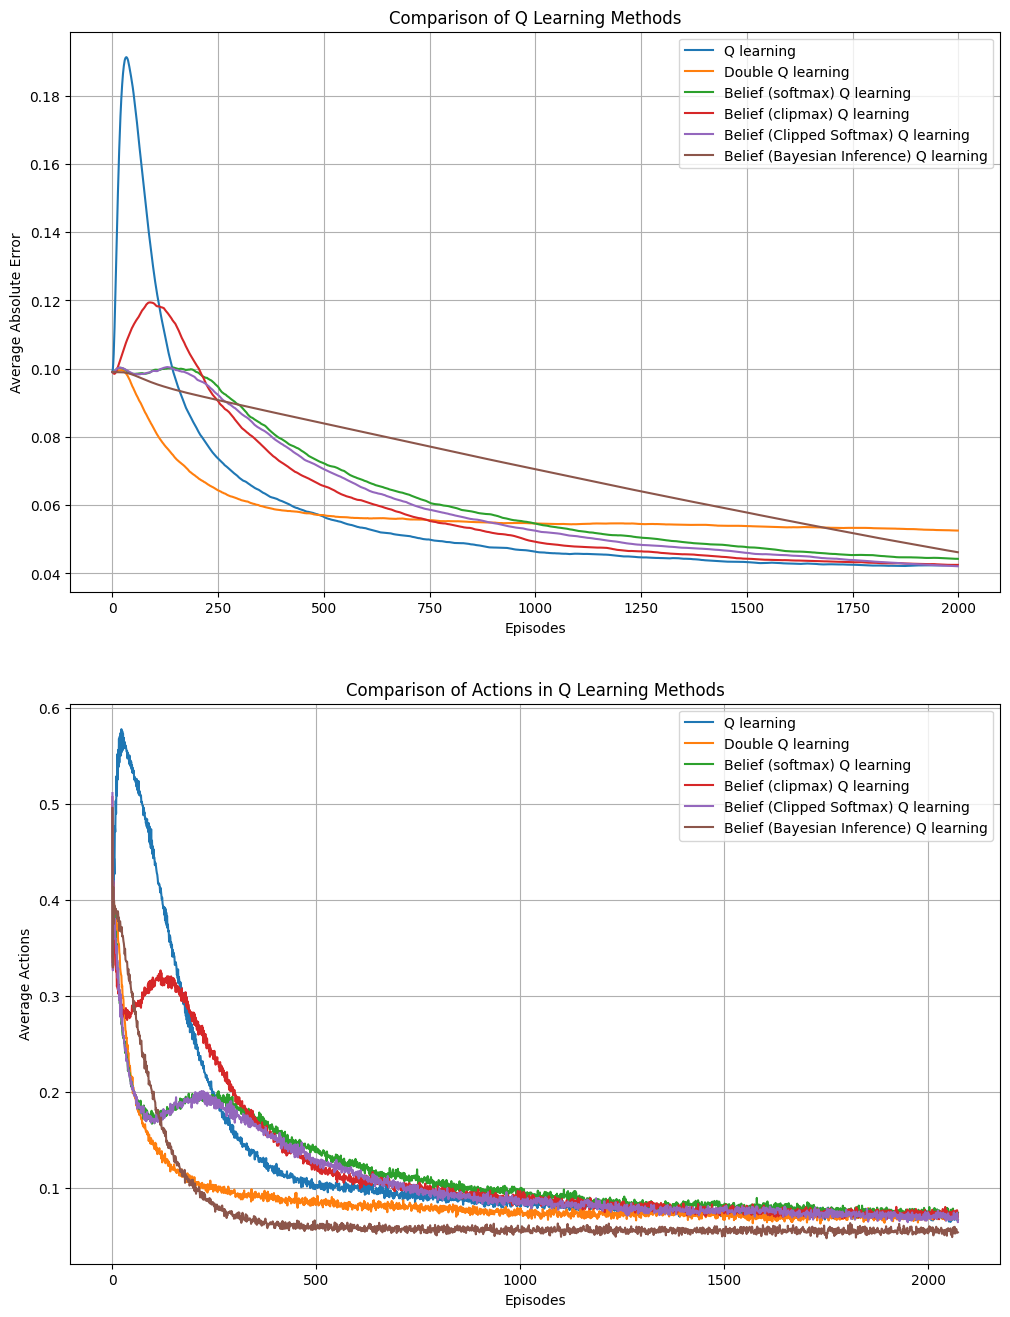

In [27]:
# fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig, axs = plt.subplots(2, figsize=(12, 16))
# Plot the average absolute errors for each method
axs[0].plot(avg_abs_error_Q, label='Q learning')
axs[0].plot(avg_abs_error_dQ, label='Double Q learning')
axs[0].plot(avg_abs_error_sQ, label='Belief (softmax) Q learning')
axs[0].plot(avg_abs_error_cQ, label='Belief (clipmax) Q learning')
# axs[0].plot(avg_abs_error_adQ, label='Mental Modal Q learning')
axs[0].plot(avg_abs_error_csQ, label='Belief (Clipped Softmax) Q learning')
axs[0].plot(avg_abs_error_bQ, label='Belief (Bayesian Inference) Q learning')
axs[0].legend()
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel('Average Absolute Error')
axs[0].set_title('Comparison of Q Learning Methods')
axs[0].grid(True)

# Plot the average actions for each method
axs[1].plot(avg_action_Q, label='Q learning')
axs[1].plot(avg_action_dQ, label='Double Q learning')
axs[1].plot(avg_action_sQ, label='Belief (softmax) Q learning')
axs[1].plot(avg_action_cQ, label='Belief (clipmax) Q learning')
# axs[1].plot(avg_action_adQ, label='Mental Modal Q learning')
axs[1].plot(avg_action_csQ, label='Belief (Clipped Softmax) Q learning')
axs[1].plot(avg_action_bQ, label='Belief (Bayesian Inference) Q learning')
axs[1].legend()
axs[1].set_xlabel('Episodes')
axs[1].set_ylabel('Average Actions')
axs[1].set_title('Comparison of Actions in Q Learning Methods')
axs[1].grid(True)
# Display the figure
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# 
# # Define the Gaussian distribution function
# def gauss(x, mean=0, std_dev=1):
#     return 1/(std_dev * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
# 
# # Define the range for plotting and Riemann sum
# x_values = np.linspace(-4, 4, 1000)  # For a smooth plot
# x_riemann = np.linspace(-4, 4, 21)  # For Riemann sum rectangles
# 
# # Calculate midpoints of the intervals
# x_mid = (x_riemann[:-1] + x_riemann[1:]) / 2
# 
# # Evaluate the Gaussian function
# mean = 0
# std_dev = 1
# y_values = gauss(x_values, mean, std_dev)
# y_mid = gauss(x_mid, mean, std_dev)
# 
# # Plot the Gaussian function
# plt.figure(figsize=(10, 6))
# plt.plot(x_values, y_values, label='Gaussian Function', color='black')
# 
# # Define the height and width of the blue rectangle for Q-Learning
# blue_rect_height = max(y_values)
# blue_rect_width = x_values[-1] - x_values[0]
# blue_rect_x = x_values[0]
# 
# # Add the blue rectangle for Q-Learning
# plt.gca().add_patch(plt.Rectangle((blue_rect_x, 0), blue_rect_width, blue_rect_height, color='blue', alpha=0.1))
# 
# # Plot the Riemann sum rectangles for Belief Q-Learning
# dx = x_riemann[1] - x_riemann[0]
# for i in range(len(x_mid)):
#     x0 = x_riemann[i]
#     height = y_mid[i]
#     plt.gca().add_patch(plt.Rectangle((x0, 0), dx, height, color='grey', alpha=0.3))
# 
# # Adding lines for rectangles
# plt.vlines(x_mid, 0, y_mid, colors='grey', linestyles='dashed')
# 
# # Add annotations for Q-Learning and Belief Q-Learning
# plt.text(blue_rect_x + blue_rect_width/3, blue_rect_height * 0.6, 'Q-Learning', fontsize=12, ha='right', color='blue')
# plt.text(0, max(y_mid) * 0.6, 'Belief Q-Learning', fontsize=12, ha='center', color='black')
# 
# # Plot formatting
# plt.xlabel('x')
# plt.ylabel('Probability Density')
# # plt.title('Gaussian Function with Q-Learning and Belief Q-Learning Approximation')
# # plt.grid(True)
# plt.tight_layout()
# 
# plt.show()
